### In this notebook we will try to use ML to predict the betting line
Based on this work : http://cs229.stanford.edu/proj2013/ChengDadeLipmanMills-PredictingTheBettingLineInNBAGames.pdf


## Import libraries

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from datetime import date
import datetime
import requests

from scipy.stats import poisson

import nba_api
from nba_api.stats.static import teams
from nba_api.stats.endpoints import leaguegamefinder
from nba_api.stats.static import players
from nba_api.stats.endpoints import playergamelog
from nba_api.stats.endpoints import teamgamelogs
from nba_api.stats.endpoints import teamandplayersvsplayers

import seaborn as sns
sns.set()
# scatter matrix makes a matrix of scatter plots
from pandas.plotting import scatter_matrix

## Let's pull some team/game info from the NBA API

In [2]:
#2015-2016 regular season start and end dates
start_15_16 = '2015-10-27'
end_15_16 = '2016-04-13'

#2016-2017 regular season start and end dates
start_16_17 = '2016-10-25'
end_16_17 = '2017-04-12'

#2016-2017 regular season start and end dates
start_17_18 = '2017-10-17'
end_17_18 = '2018-04-11'

#2018-2019 regular season start and end dates
start_18_19 = '2018-10-16'
end_18_19 = '2019-04-10'

In [3]:
teams_df = pd.DataFrame(teams.get_teams())
teams_df.rename(columns={'id':'TEAM_ID'}, inplace=True)
teams_df.head()

,abbreviation,city,full_name,TEAM_ID,nickname,state,year_founded
0,ATL,Atlanta,Atlanta Hawks,1610612737,Hawks,Atlanta,1949
1,BOS,Boston,Boston Celtics,1610612738,Celtics,Massachusetts,1946
2,CLE,Cleveland,Cleveland Cavaliers,1610612739,Cavaliers,Ohio,1970
3,NOP,New Orleans,New Orleans Pelicans,1610612740,Pelicans,Louisiana,2002
4,CHI,Chicago,Chicago Bulls,1610612741,Bulls,Illinois,1966


In [4]:
# Get **all** the games so we can filter to an individual GAME_ID
result = leaguegamefinder.LeagueGameFinder()
all_games = result.get_data_frames()[0]
all_games.head()

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS
0,22019,1612709926,MHU,Memphis Hustle,2021900026,2020-03-15,MHU vs. IWA,None,120,56,...,1.000,7,17,24,13,5,1,4,7,15.6
1,22019,1612709911,IWA,Iowa Wolves,2021900026,2020-03-15,IWA @ MHU,None,107,41,...,0.833,2,15,17,8,1,7,11,8,-16.2
2,22019,1612709914,STO,Stockton Kings,2021900570,2020-03-11,STO vs. OKL,W,241,131,...,0.667,15,29,44,29,9,1,14,20,4.0
3,22019,1610612737,ATL,Atlanta Hawks,0021900969,2020-03-11,ATL vs. NYK,L,265,131,...,0.808,15,38,53,26,6,3,17,25,0.0
4,22019,1612709909,DEL,Delaware Blue Coats,2021900564,2020-03-11,DEL vs. MNE,W,240,113,...,0.800,3,40,43,23,14,10,16,18,21.0


In [5]:
#match NBA teams from 'teams_df' with 'all_games' to remove
#all non NBA-games from 'all_games' 
nba_games = pd.merge(teams_df, all_games, on = 'TEAM_ID', how = 'inner')
nba_games.head()

,abbreviation,city,full_name,TEAM_ID,nickname,state,year_founded,SEASON_ID,TEAM_ABBREVIATION,TEAM_NAME,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS
0,ATL,Atlanta,Atlanta Hawks,1610612737,Hawks,Atlanta,1949,22019,ATL,Atlanta Hawks,...,0.808,15,38,53,26,6,3,17,25,0.0
1,ATL,Atlanta,Atlanta Hawks,1610612737,Hawks,Atlanta,1949,22019,ATL,Atlanta Hawks,...,0.593,12,41,53,33,1,5,15,26,5.0
2,ATL,Atlanta,Atlanta Hawks,1610612737,Hawks,Atlanta,1949,22019,ATL,Atlanta Hawks,...,0.857,14,32,46,23,9,2,14,24,-17.0
3,ATL,Atlanta,Atlanta Hawks,1610612737,Hawks,Atlanta,1949,22019,ATL,Atlanta Hawks,...,0.667,6,30,36,25,9,4,17,25,-6.0
4,ATL,Atlanta,Atlanta Hawks,1610612737,Hawks,Atlanta,1949,22019,ATL,Atlanta Hawks,...,0.938,16,27,43,20,6,8,17,21,-39.0


In [6]:
#function searches rows in 'nba_games' df sharing same 'GAME_ID' and sums PTS
#to obtain sum of final score
def total_pts_game(id_game):
    return np.sum(nba_games.loc[nba_games['GAME_ID'] == str(id_game)][['PTS']])

In [7]:
#uses 'total_pts_game' function to create df of sum of final score for
#all games in 'nba_games' df
total_points = pd.DataFrame(list(map(lambda x : total_pts_game(nba_games['GAME_ID'][x]), list(range(len(nba_games))))))

In [8]:
#appends new column to 'nba_games' df containing combined final score per game
nba_games['COMBINED_FINAL_SCORE'] = total_points
nba_games.head()

,abbreviation,city,full_name,TEAM_ID,nickname,state,year_founded,SEASON_ID,TEAM_ABBREVIATION,TEAM_NAME,...,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS,COMBINED_FINAL_SCORE
0,ATL,Atlanta,Atlanta Hawks,1610612737,Hawks,Atlanta,1949,22019,ATL,Atlanta Hawks,...,15,38,53,26,6,3,17,25,0.0,267
1,ATL,Atlanta,Atlanta Hawks,1610612737,Hawks,Atlanta,1949,22019,ATL,Atlanta Hawks,...,12,41,53,33,1,5,15,26,5.0,281
2,ATL,Atlanta,Atlanta Hawks,1610612737,Hawks,Atlanta,1949,22019,ATL,Atlanta Hawks,...,14,32,46,23,9,2,14,24,-17.0,219
3,ATL,Atlanta,Atlanta Hawks,1610612737,Hawks,Atlanta,1949,22019,ATL,Atlanta Hawks,...,6,30,36,25,9,4,17,25,-6.0,230
4,ATL,Atlanta,Atlanta Hawks,1610612737,Hawks,Atlanta,1949,22019,ATL,Atlanta Hawks,...,16,27,43,20,6,8,17,21,-39.0,215


In [9]:
#mask to filter dates within range
mask_15_16 = (nba_games['GAME_DATE'] >= start_15_16) & (nba_games['GAME_DATE'] <= end_15_16)
mask_16_17 = (nba_games['GAME_DATE'] >= start_16_17) & (nba_games['GAME_DATE'] <= end_16_17)
mask_17_18 = (nba_games['GAME_DATE'] >= start_17_18) & (nba_games['GAME_DATE'] <= end_17_18)
mask_18_19 = (nba_games['GAME_DATE'] >= start_18_19) & (nba_games['GAME_DATE'] <= end_18_19)

In [10]:
#regular season games held between given seasons
nba_games_15_16 = nba_games.loc[mask_15_16]
nba_games_16_17 = nba_games.loc[mask_16_17]
nba_games_17_18 = nba_games.loc[mask_17_18]
nba_games_18_19 = nba_games.loc[mask_18_19]

In [11]:
nba_games_15_16.head()

,abbreviation,city,full_name,TEAM_ID,nickname,state,year_founded,SEASON_ID,TEAM_ABBREVIATION,TEAM_NAME,...,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS,COMBINED_FINAL_SCORE
377,ATL,Atlanta,Atlanta Hawks,1610612737,Hawks,Atlanta,1949,22015,ATL,Atlanta Hawks,...,9,38,47,22,13,5,22,21,-11.0,207
378,ATL,Atlanta,Atlanta Hawks,1610612737,Hawks,Atlanta,1949,22015,ATL,Atlanta Hawks,...,10,32,42,23,8,6,15,18,-15.0,203
379,ATL,Atlanta,Atlanta Hawks,1610612737,Hawks,Atlanta,1949,22015,ATL,Atlanta Hawks,...,5,39,44,31,10,10,17,22,11.0,225
380,ATL,Atlanta,Atlanta Hawks,1610612737,Hawks,Atlanta,1949,22015,ATL,Atlanta Hawks,...,5,36,41,23,4,12,13,19,8.0,182
381,ATL,Atlanta,Atlanta Hawks,1610612737,Hawks,Atlanta,1949,22015,ATL,Atlanta Hawks,...,13,37,50,26,16,3,16,21,13.0,193


## Section II : Basic Models

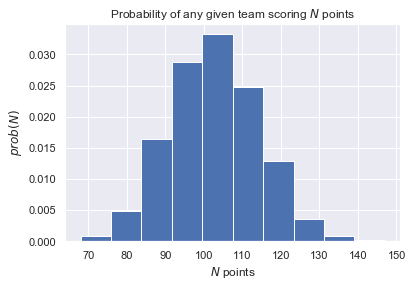

In [19]:
plt.hist(nba_games_15_16['PTS'], density=True)
plt.title(r'Probability of any given team scoring $N$ points')
plt.xlabel(r'$N$ points')
plt.ylabel(r'$prob(N)$')
plt.show()

The authors say they did linear regression of Home team points per game on Score, etc...

Let's see if those two things are correlated?

In [23]:
nba_games_15_16.columns

Index(['abbreviation', 'city', 'full_name', 'TEAM_ID', 'nickname', 'state',
       'year_founded', 'SEASON_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME',
       'GAME_ID', 'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'PTS', 'FGM', 'FGA',
       'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB',
       'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PLUS_MINUS',
       'COMBINED_FINAL_SCORE'],
      dtype='object')

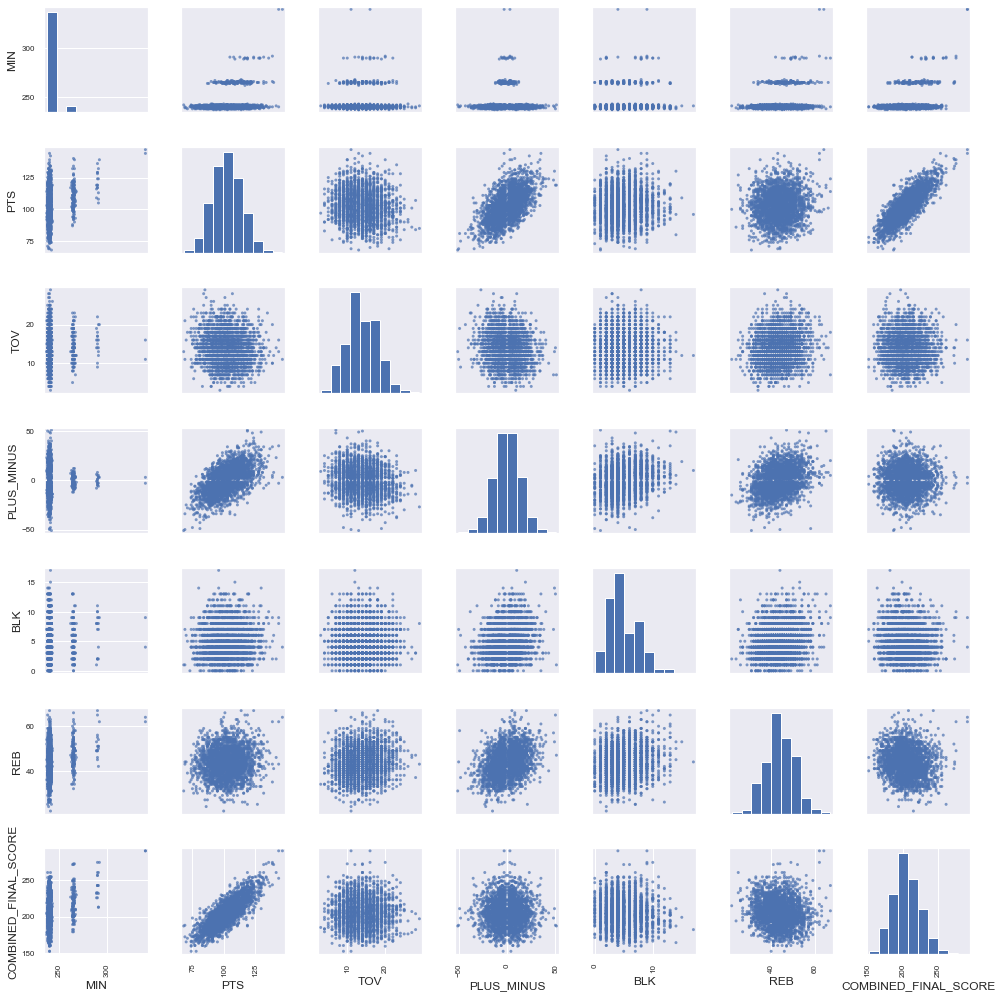

In [25]:
cols = ['WL', 'MIN', 'PTS', 'TOV', 'PLUS_MINUS', 'BLK', 'REB', 'COMBINED_FINAL_SCORE']

scatter_matrix(nba_games_15_16[cols], figsize = (14,14), alpha = 0.7)
plt.tight_layout(True)
plt.show()

The prompt from SIG suggests using the following info:
1. Identities of team A and B
2. Home/Away status 
3. Travel/Risk factors (e.g. Are they back-to-back games? What’s the travel distance?)
4. Recent performances
5. Pace
6. Tendency toward blowouts (scoring is lower once a game is decided)
7. Referees (refs who call more fouls increase scoring)

However, we should only use information that we can know **before** the game is played!
So that excludes Pace and blowouts...


## Is there a seasonal effect (Are teams more likely to score more/less depending on the time in the season?)

/Users/derek/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


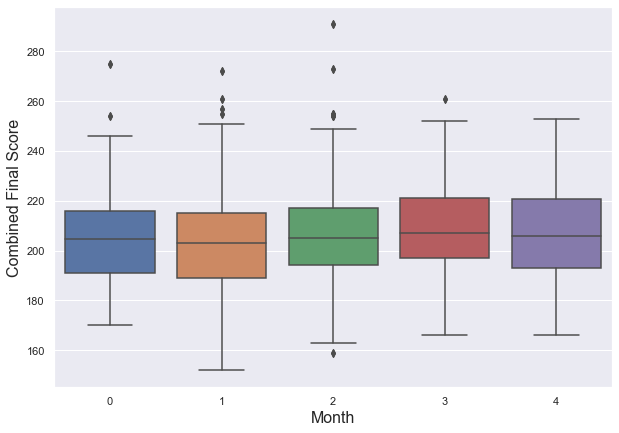

In [59]:
#The NBA Season begins in October?
nba_games_15_16['MONTH'] = pd.to_datetime(nba_games_15_16['GAME_DATE']).dt.month % 10

fig, ax = plt.subplots(1,1, figsize=(10,7))
sns.boxplot(data = nba_games_15_16, x="MONTH", y="COMBINED_FINAL_SCORE", ax = ax)
plt.xlabel("Month", fontsize = 16)
plt.ylabel("Combined Final Score", fontsize = 16)
plt.show()

## Its not clear if there is a strong seasonal trend in 2015-2016

/Users/derek/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


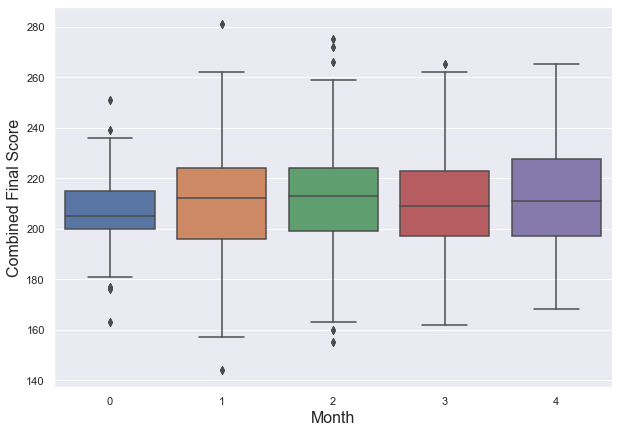

In [61]:
#The NBA Season begins in October?
nba_games_16_17['MONTH'] = pd.to_datetime(nba_games_16_17['GAME_DATE']).dt.month % 10

fig, ax = plt.subplots(1,1, figsize=(10,7))
sns.boxplot(data = nba_games_16_17, x="MONTH", y="COMBINED_FINAL_SCORE", ax = ax)
plt.xlabel("Month", fontsize = 16)
plt.ylabel("Combined Final Score", fontsize = 16)
plt.show()

## No clear seasonal trend in 2016-2017 either...

## Look for trend between which team is playing and Final Score

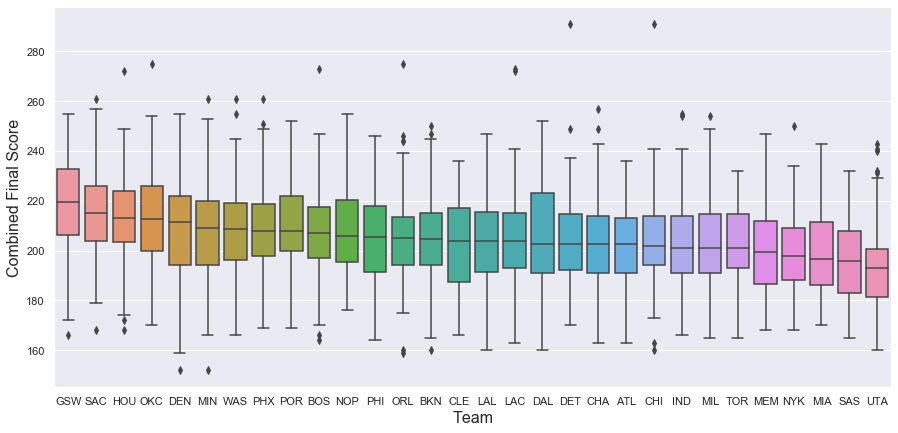

In [65]:
fig, ax = plt.subplots(1,1, figsize=(15,7))
order = nba_games_15_16.groupby(by=['TEAM_ABBREVIATION'])['COMBINED_FINAL_SCORE'].median().sort_values(ascending=False).index
sns.boxplot(data = nba_games_15_16, x="abbreviation", y="COMBINED_FINAL_SCORE", ax = ax, order=order)
plt.xlabel("Team", fontsize = 16)
plt.ylabel("Combined Final Score", fontsize = 16)
plt.show()

### So it seems that which team is playing is important for the combined score... up to about 20-30 points